In [1]:
import gc
import matplotlib.pyplot as plt
plt.close('all')
gc.collect()
print("Memoria liberada.")

Memoria liberada.


       📊 LOG DE AUDITORÍA: CARGA DE VOLUMEN
Caso Analizado           : ATM_001
Ruta Imagen              : ./TrainBatch1/imagesTr\ATM_001_0000.nii.gz
Ruta Label               : ./TrainBatch1/labelsTr\ATM_001_0000.nii.gz
Dimensión del Volumen    : (512, 512, 679)
Espaciado (mm)           : (np.float32(0.82), np.float32(0.82), np.float32(0.5))
HU Mín (Original)        : -1024.0
HU Máx (Original)        : 3071.0


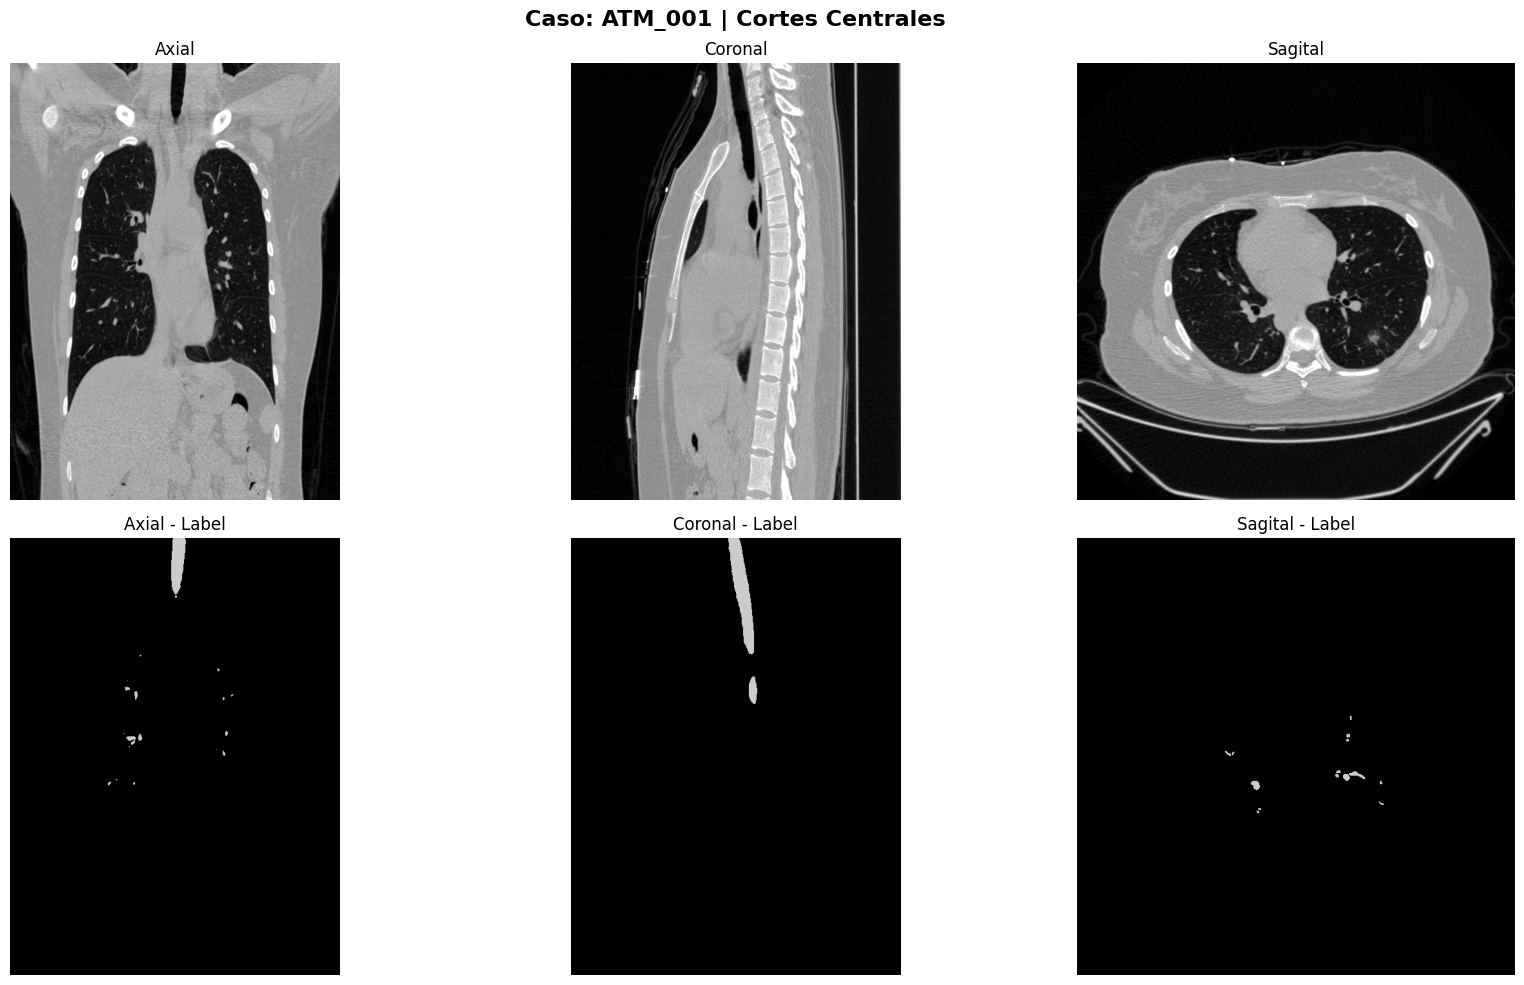

In [2]:
# =========================
# Cell 1: Carga de un Volumen Único para Auditoría
# Carga el primer volumen y su label correspondiente de TrainBatch1.
# Proporciona un log de auditoría y una visualización estática en los tres planos.
# =========================

import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# === 1. Configuración ===
# Rutas relativas: el notebook y TrainBatch1 están en el mismo directorio
DATA_PATHS = {
    "images_batch1": r"./TrainBatch1/imagesTr",
    "labels_batch1": r"./TrainBatch1/labelsTr",
    # "images_batch2": r"./TrainBatch2/imagesTr",  # Comentado: no está disponible
    # "labels_batch2": r"./TrainBatch2/labelsTr"   # Comentado: no está disponible
}

# === 2. Selección del primer caso ===
# Solo se usa batch1
batch_key = "batch1"
images_dir = DATA_PATHS[f"images_{batch_key}"]
labels_dir = DATA_PATHS[f"labels_{batch_key}"]

# Selecciona la PRIMERA imagen (ordenada alfabéticamente)
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".nii.gz")])
if not image_files:
    raise FileNotFoundError(f"No se encontraron imágenes en {images_dir}")

selected_image = image_files[0]  # Siempre el primero
case_id = selected_image.replace("_0000.nii.gz", "")

# Encuentra el label correspondiente
label_files = [f for f in os.listdir(labels_dir) if f.startswith(case_id) and f.endswith(".nii.gz")]
if not label_files:
    raise FileNotFoundError(f"No se encontró label para el caso '{case_id}' en {labels_dir}")
selected_label = label_files[0]

img_path = os.path.join(images_dir, selected_image)
lbl_path = os.path.join(labels_dir, selected_label)

# === 3. Carga de volúmenes ===
# Carga la imagen y el label
img_nii = nib.load(img_path)
vol_orig = img_nii.get_fdata(dtype=np.float32)
affine, header = img_nii.affine, img_nii.header

lbl_nii = nib.load(lbl_path)
vol_label = lbl_nii.get_fdata().astype(np.uint8)

# === 4. Generación del Log de Auditoría ===
audit_log = {
    "Caso Analizado": case_id,
    "Ruta Imagen": img_path,
    "Ruta Label": lbl_path,
    "Dimensión del Volumen": vol_orig.shape,
    "Espaciado (mm)": tuple(round(s, 3) for s in header.get_zooms()),
    "HU Mín (Original)": float(vol_orig.min()),
    "HU Máx (Original)": float(vol_orig.max()),
}

print("=" * 50)
print("       📊 LOG DE AUDITORÍA: CARGA DE VOLUMEN")
print("=" * 50)
for key, value in audit_log.items():
    print(f"{key:<25}: {value}")
print("=" * 50)

# === 5. Visualización Estática en los Tres Planos Centrales ===
# Obtener los índices centrales
z_mid = vol_orig.shape[0] // 2
y_mid = vol_orig.shape[1] // 2
x_mid = vol_orig.shape[2] // 2

# Extraer y rotar los cortes centrales
axial_vol   = np.rot90(vol_orig[:, y_mid, :], k=1)
coronal_vol = np.rot90(vol_orig[z_mid, :, :], k=1)
sagittal_vol = np.rot90(vol_orig[:, :, x_mid], k=-1)

axial_lbl   = np.rot90(vol_label[:, y_mid, :], k=1)
coronal_lbl = np.rot90(vol_label[z_mid, :, :], k=1)
sagittal_lbl = np.rot90(vol_label[:, :, x_mid], k=-1)

# Crear la figura
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f"Caso: {case_id} | Cortes Centrales", fontsize=16, weight='bold')

# Panel 1: TC Original
axes[0, 0].imshow(axial_vol, cmap="gray", vmin=-1024, vmax=600)
axes[0, 0].set_title("Axial", fontsize=12)
axes[0, 0].axis("off")

axes[0, 1].imshow(coronal_vol, cmap="gray", vmin=-1024, vmax=600)
axes[0, 1].set_title("Coronal", fontsize=12)
axes[0, 1].axis("off")

axes[0, 2].imshow(sagittal_vol, cmap="gray", vmin=-1024, vmax=600)
axes[0, 2].set_title("Sagital", fontsize=12)
axes[0, 2].axis("off")

# Panel 2: Label Manual (Ground Truth)
axes[1, 0].imshow(axial_lbl, cmap="nipy_spectral", vmin=0, vmax=vol_label.max())
axes[1, 0].set_title("Axial - Label", fontsize=12)
axes[1, 0].axis("off")

axes[1, 1].imshow(coronal_lbl, cmap="nipy_spectral", vmin=0, vmax=vol_label.max())
axes[1, 1].set_title("Coronal - Label", fontsize=12)
axes[1, 1].axis("off")

axes[1, 2].imshow(sagittal_lbl, cmap="nipy_spectral", vmin=0, vmax=vol_label.max())
axes[1, 2].set_title("Sagital - Label", fontsize=12)
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

In [3]:
# =========================
# Cell 2: Definición de Técnicas de Preprocesamiento
# Incluye una normalización que puede ser revertida para la segmentación clásica.
# =========================

import numpy as np

# -------------------------
# Helper: ensure ROI and volume have the same shape
# -------------------------
def match_shape(vol, roi):
    """Ajusta ROI para que coincida con la forma del volumen (crop/pad centrado)."""
    if roi is None:
        return None
    roi = roi.astype(bool, copy=False)
    Z, Y, X = vol.shape
    rz, ry, rx = roi.shape

    # Crop ROI si es más grande
    if rz > Z or ry > Y or rx > X:
        z0 = max((rz - Z) // 2, 0)
        y0 = max((ry - Y) // 2, 0)
        x0 = max((rx - X) // 2, 0)
        roi = roi[z0:z0+Z, y0:y0+Y, x0:x0+X]

    # Pad ROI si es más pequeña
    diffZ = Z - roi.shape[0]
    diffY = Y - roi.shape[1]
    diffX = X - roi.shape[2]
    if diffZ > 0 or diffY > 0 or diffX > 0:
        pad_width = (
            (0, max(diffZ, 0)),
            (0, max(diffY, 0)),
            (0, max(diffX, 0)),
        )
        roi = np.pad(roi, pad_width, mode="constant", constant_values=False)

    return roi[:Z, :Y, :X]

# -------------------------
# 1) HU Clipping
# -------------------------
def apply_hu_clipping(volume, hu_min=-1024, hu_max=600):
    """
    Aplica clipping en HU al rango [hu_min, hu_max].
    """
    return np.clip(volume.astype(np.float32, copy=False), hu_min, hu_max)

# -------------------------
# 2) Gaussian Smoothing
# -------------------------
def apply_gaussian_smoothing(volume, sigma=0.8):
    """
    Aplica suavizado gaussiano isotrópico.
    - sigma=0.8: un valor ligeramente más conservador que 1.0 para preservar vías finas.
    """
    from scipy.ndimage import gaussian_filter
    return gaussian_filter(volume.astype(np.float32), sigma=sigma)

# -------------------------
# 3) Normalización Min-Max con Reversión
# -------------------------
# Diccionario global para guardar los parámetros de normalización por caso.
_NORMALIZATION_PARAMS = {}

def apply_minmax_normalization(volume, case_id="default"):
    """
    Aplica normalización Min-Max al rango [0, 1] usando los valores reales del volumen.
    Guarda los parámetros para su reversión.
    """
    vol_float = volume.astype(np.float32, copy=False)
    vol_min, vol_max = vol_float.min(), vol_float.max()
    normalized = (vol_float - vol_min) / (vol_max - vol_min + 1e-8)  # Evitar división por cero
    # Guardar los parámetros usando el case_id para su posterior reversión
    _NORMALIZATION_PARAMS[case_id] = (vol_min, vol_max)
    return normalized

def revert_normalization(normalized_volume, case_id="default"):
    """
    Revierte la normalización Min-Max para recuperar la escala de HU original.
    Esta función DEBE llamarse antes de la segmentación clásica si se aplicó normalización.
    """
    if case_id not in _NORMALIZATION_PARAMS:
        raise ValueError(f"No se encontraron parámetros de normalización para el caso '{case_id}'. "
                         f"Asegúrate de que `apply_minmax_normalization` se llamó primero.")
    vol_min, vol_max = _NORMALIZATION_PARAMS[case_id]
    return normalized_volume * (vol_max - vol_min) + vol_min

# -------------------------
# 4) Padding (symmetrical, multiples of 32)
# -------------------------
def apply_padding_32(volume, pad_value=-1024):
    """
    Aplica padding simétrico para ajustar a múltiplos de 32.
    Usa el valor de aire exterior (-1024) como constante de relleno.
    """
    shape = volume.shape
    pad_width = []
    for dim in shape:
        remainder = dim % 32
        if remainder == 0:
            pad_before, pad_after = 0, 0
        else:
            pad_total = 32 - remainder
            pad_before = pad_total // 2
            pad_after = pad_total - pad_before
        pad_width.append((pad_before, pad_after))
    
    padded = np.pad(volume, pad_width, mode='constant', constant_values=pad_value)
    return padded.astype(np.float32, copy=False)

In [4]:
# =========================
# Cell 3: Generación de Todas las Combinaciones Posibles
# Genera las 15 combinaciones no vacías de las 4 técnicas y las guarda en subcarpetas.
# =========================

import os
import itertools
from nibabel import Nifti1Image

# === 1. Configuración de rutas (relativas y alineadas) ===
OUTPUT_BASE_DIR = r"./PreProce"

# === 2. Generar las 15 combinaciones no vacías ===
all_subsets = []
for r in range(1, 5):  # De 1 a 4 técnicas
    for subset in itertools.combinations([0, 1, 2, 3], r):
        all_subsets.append(subset)

assert len(all_subsets) == 15, "Debe haber exactamente 15 combinaciones no vacías."

print(f"Generando las 15 combinaciones posibles para el volumen {case_id}...")

# === 3. Procesar y guardar cada combinación en su propia carpeta ===
for i, combo in enumerate(all_subsets):
    vol = vol_orig.copy()
    
    apply_clipping = 0 in combo
    apply_smoothing = 1 in combo
    apply_normalization = 2 in combo
    apply_padding = 3 in combo
    
    # Aplicar en orden lógico
    if apply_clipping:
        vol = apply_hu_clipping(vol)
    if apply_smoothing:
        vol = apply_gaussian_smoothing(vol)
    if apply_normalization:
        # CORREGIDO: Se pasa el case_id para que la normalización pueda revertirse después
        vol = apply_minmax_normalization(vol, case_id=case_id)
    if apply_padding:
        vol = apply_padding_32(vol)
    
    # Crear el nombre de la subcarpeta y del archivo
    name_parts = []
    if apply_clipping: name_parts.append("Clipped")
    if apply_smoothing: name_parts.append("Smoothed")
    if apply_normalization: name_parts.append("Normalized")
    if apply_padding: name_parts.append("Padded")
    
    folder_name = "_".join(name_parts) if name_parts else "Original"
    full_output_dir = os.path.join(OUTPUT_BASE_DIR, folder_name)
    os.makedirs(full_output_dir, exist_ok=True)
    
    output_filename = selected_image
    output_path = os.path.join(full_output_dir, output_filename)
    
    output_nii = Nifti1Image(vol, affine=affine)
    nib.save(output_nii, output_path)

print(f"✅ Las 15 combinaciones han sido guardadas en subcarpetas dentro de '{OUTPUT_BASE_DIR}'.")

Generando las 15 combinaciones posibles para el volumen ATM_001...
✅ Las 15 combinaciones han sido guardadas en subcarpetas dentro de './PreProce'.


✅ Cargado: Clipped
✅ Cargado: Clipped_Normalized
✅ Cargado: Clipped_Normalized_Padded
✅ Cargado: Clipped_Padded
✅ Cargado: Clipped_Smoothed
✅ Cargado: Clipped_Smoothed_Normalized
✅ Cargado: Clipped_Smoothed_Normalized_Padded
✅ Cargado: Clipped_Smoothed_Padded
✅ Cargado: Normalized
✅ Cargado: Normalized_Padded
✅ Cargado: Padded
✅ Cargado: Smoothed
✅ Cargado: Smoothed_Normalized
✅ Cargado: Smoothed_Normalized_Padded
✅ Cargado: Smoothed_Padded

Generando mosaico con 16 combinaciones...


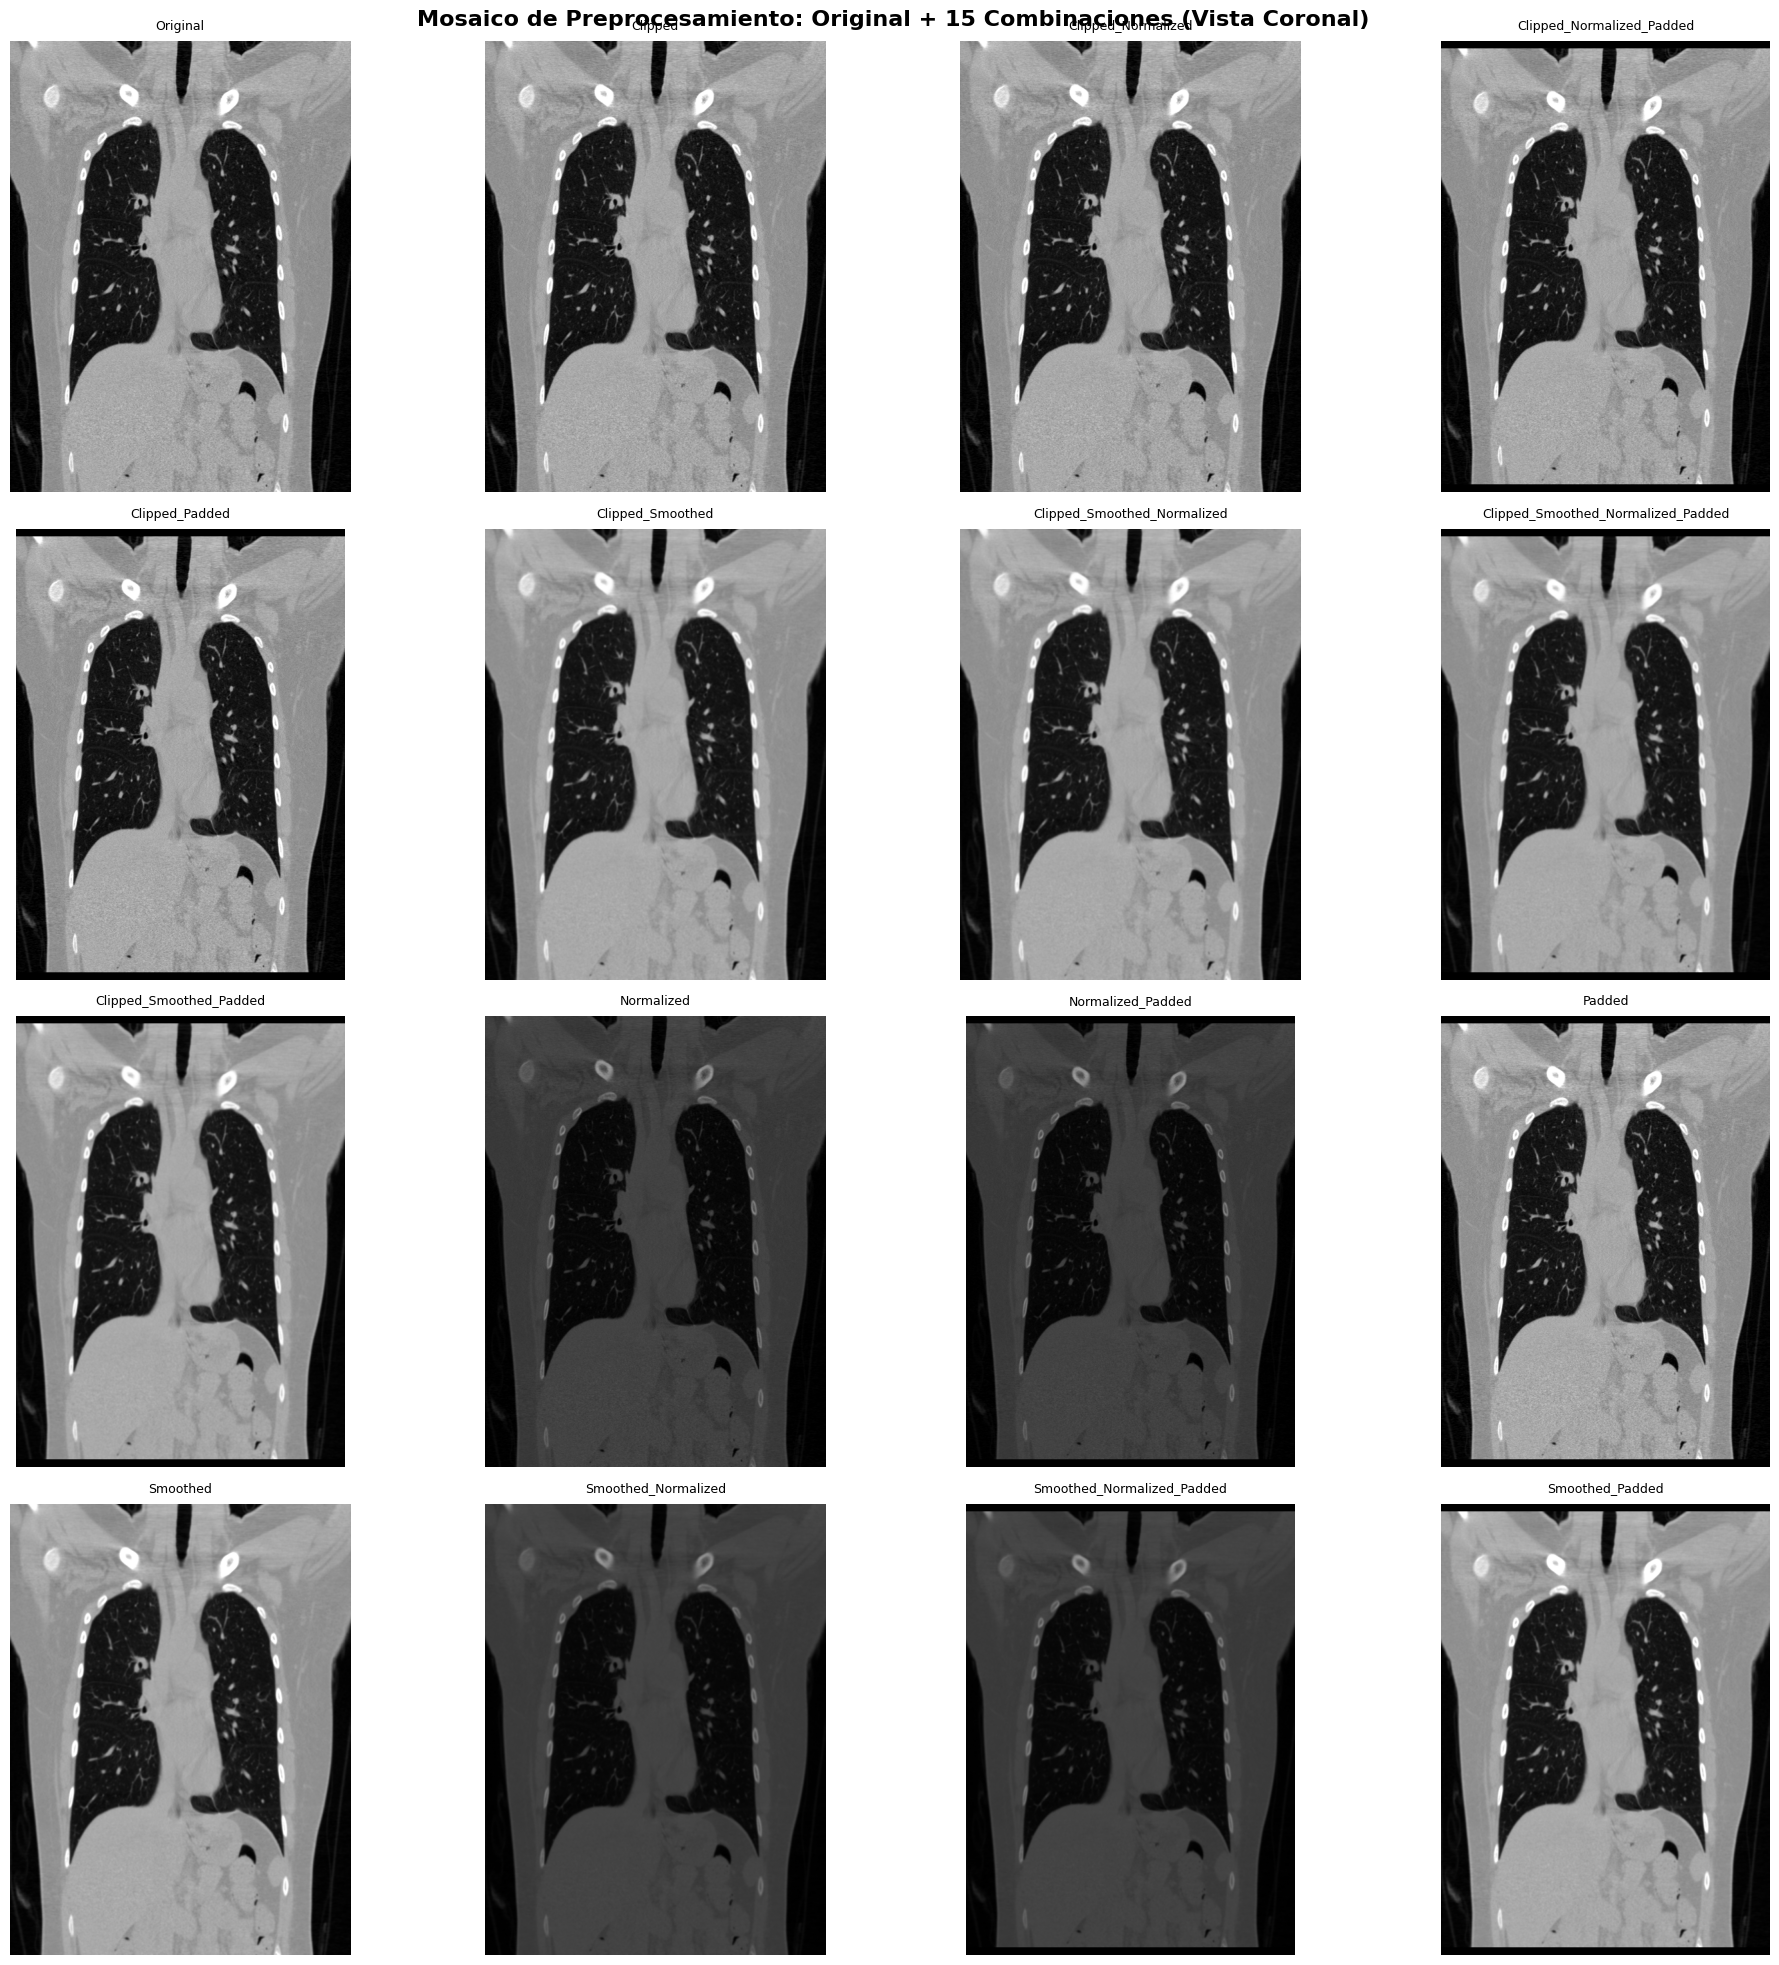


✅ Mosaico generado exitosamente con 16 combinaciones.


In [5]:
# =========================
# Cell 3b: Mosaico de las 16 Combinaciones (VISTA CORONAL)
# Muestra el volumen original + las 15 combinaciones en un mosaico 4x4 con vista coronal.
# Usa carga parcial para evitar MemoryError.
# =========================

import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

def load_coronal_slice(nii_path):
    """Carga solo el corte coronal central sin cargar todo el volumen en memoria."""
    img = nib.load(nii_path)
    header = img.header
    shape = header.get_data_shape()
    
    # Obtener el índice del corte coronal central (eje Y)
    y_mid = shape[1] // 2
    
    # Leer solo el corte específico
    data_obj = img.dataobj
    if hasattr(data_obj, '__getitem__'):
        # Cargar solo el corte coronal necesario
        coronal_slice = np.asarray(data_obj[:, y_mid, :], dtype=np.float32)
    else:
        # Fallback: cargar todo (menos eficiente pero seguro)
        vol = img.get_fdata(dtype=np.float32)
        coronal_slice = vol[:, y_mid, :]
    
    return coronal_slice, shape

# === 1. Preparar los datos para el mosaico ===
mosaic_data = []

# Añadir el volumen original (de Cell 1) - vista coronal
y_mid_orig = vol_orig.shape[1] // 2
original_coronal = vol_orig[:, y_mid_orig, :].astype(np.float32)
# Rotar para orientación correcta (como en tus otras visualizaciones)
original_coronal = np.rot90(original_coronal, k=1)
mosaic_data.append(("Original", original_coronal, -1024, 600))

# === 2. Cargar las 15 combinaciones (solo cortes coronales) ===
OUTPUT_BASE_DIR = r"./PreProce"
combination_folders = [f for f in os.listdir(OUTPUT_BASE_DIR) 
                     if os.path.isdir(os.path.join(OUTPUT_BASE_DIR, f))]

for folder in sorted(combination_folders):
    folder_path = os.path.join(OUTPUT_BASE_DIR, folder)
    nii_files = [f for f in os.listdir(folder_path) if f.endswith(".nii.gz")]
    if not nii_files:
        continue
    
    nii_path = os.path.join(folder_path, nii_files[0])
    try:
        coronal_slice, shape = load_coronal_slice(nii_path)
        # Rotar para orientación correcta
        coronal_slice = np.rot90(coronal_slice, k=1)
        
        # Determinar escala de visualización
        if "Normalized" in folder:
            vmin, vmax = 0, 1
        else:
            vmin, vmax = -1024, 600
        
        mosaic_data.append((folder, coronal_slice, vmin, vmax))
        print(f"✅ Cargado: {folder}")
        
    except Exception as e:
        print(f"⚠️  Error al cargar {folder}: {e}")
        continue

# === 3. Crear mosaico 4x4 ===
# Ordenar: Original primero, luego el resto alfabéticamente
mosaic_data.sort(key=lambda x: (x[0] != "Original", x[0]))

print(f"\nGenerando mosaico con {len(mosaic_data)} combinaciones...")

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle("Mosaico de Preprocesamiento: Original + 15 Combinaciones (Vista Coronal)", fontsize=16, fontweight="bold")

for idx, (title, slice_img, vmin, vmax) in enumerate(mosaic_data[:16]):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]
    
    ax.imshow(slice_img, cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=9, pad=8)
    ax.axis('off')

# Ocultar ejes sobrantes
for idx in range(len(mosaic_data), 16):
    row = idx // 4
    col = idx % 4
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✅ Mosaico generado exitosamente con {len(mosaic_data)} combinaciones.")

[Cell 4] ROI → voxeles=12632272, componentes=1, semillas=2244
✅ ROI guardada en: ./PreProce\ATM_001_roi.nii.gz


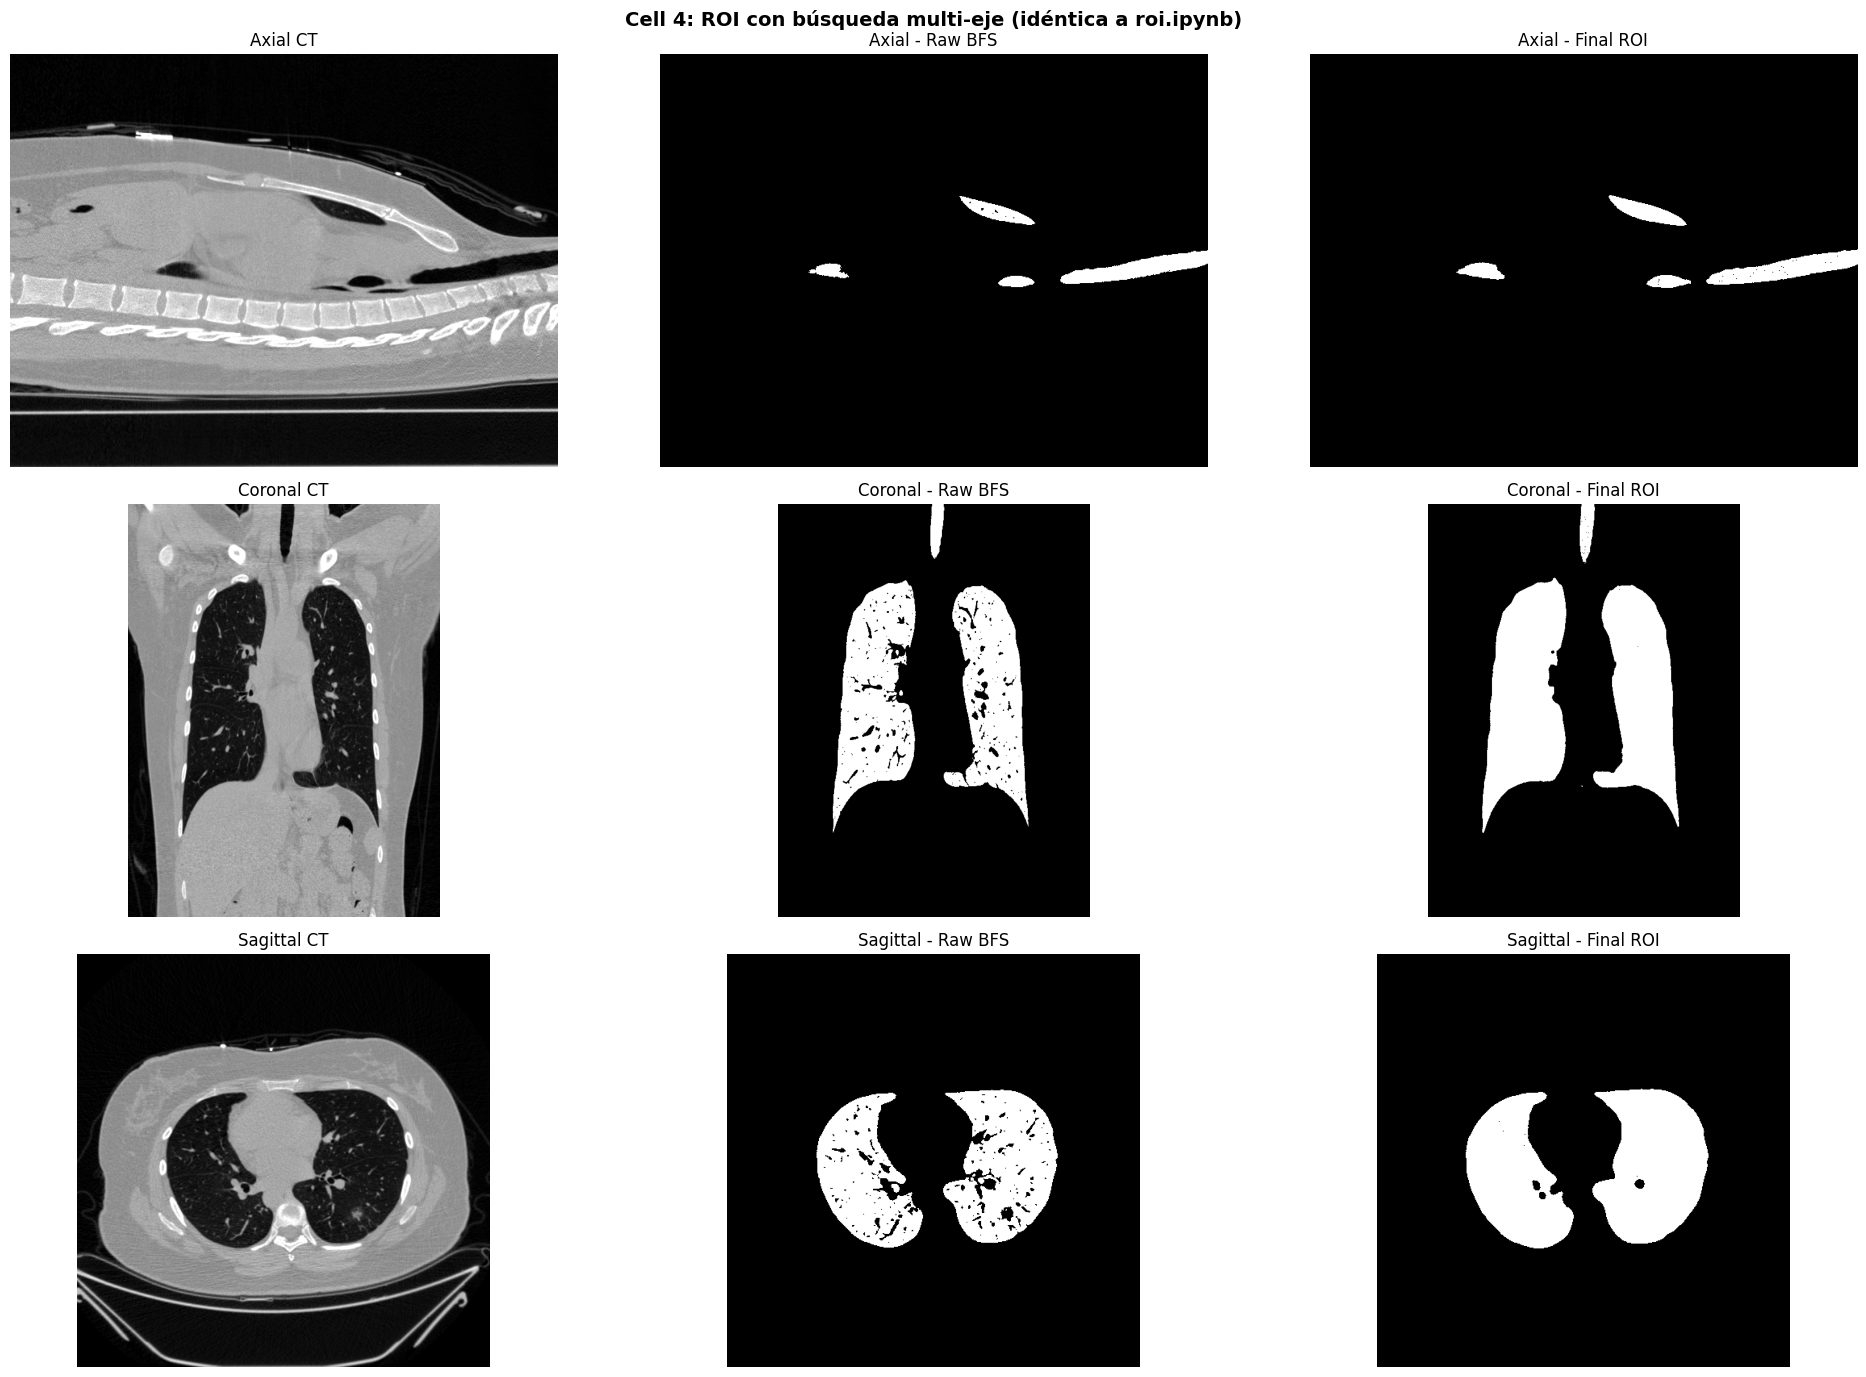

In [6]:
# =========================
# Cell 4: Generación de ROI Única desde Volumen Original
# IDÉNTICA a Cell 2-3 de roi.ipynb, solo añade guardado en ./PreProce/
# =========================

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, binary_closing, binary_dilation, ball
from skimage.segmentation import clear_border
from scipy.ndimage import label as cc_label, binary_fill_holes
from collections import deque

# === Verificación de dependencias ===
assert 'vol_orig' in globals(), "vol_orig no encontrado. Ejecuta la Cell 1."
assert 'affine' in globals(), "affine no encontrado. Ejecuta la Cell 1."

# === Aplicar HU Clipping básico (igual que en roi.ipynb) ===
vol_clip = np.clip(vol_orig, -1024, 600)

# --- Parámetros optimizados ---
AIR_THR_STRICT = -950
GROW_THR = -700
MIN_SIZE = 50
SMOOTH_RADIUS = 5

Z, Y, X = vol_clip.shape

# --- Paso 1: Semillas con búsqueda multi-eje ---
seeds = (vol_clip <= AIR_THR_STRICT)
seeds = clear_border(seeds)
seeds = remove_small_objects(seeds, min_size=MIN_SIZE)

# ✅ Regiones de búsqueda para cada eje
delta_z = Z // 10
delta_y = Y // 8
delta_x = X // 8

# Axial: alrededor de Z//2
axial_region = np.zeros_like(seeds, dtype=bool)
z_axial = Z // 2
axial_region[max(0, z_axial - delta_z):min(Z, z_axial + delta_z), :, :] = True

# Coronal: alrededor de Y//2
coronal_region = np.zeros_like(seeds, dtype=bool)
y_coronal = Y // 2
coronal_region[:, max(0, y_coronal - delta_y):min(Y, y_coronal + delta_y), :] = True

# Sagittal: alrededor de X//2
sagittal_region = np.zeros_like(seeds, dtype=bool)
x_sagittal = X // 2
sagittal_region[:, :, max(0, x_sagittal - delta_x):min(X, x_sagittal + delta_x)] = True

# ✅ Intersección de regiones
search_region = axial_region & coronal_region & sagittal_region
trachea_cand = seeds & search_region

# --- Detección de tráquea ---
trachea = np.zeros_like(seeds, dtype=bool)
labeled_top, n_top = cc_label(trachea_cand)

if n_top > 0:
    sizes = np.bincount(labeled_top.ravel())
    sizes[0] = 0
    main_label = np.argmax(sizes)
    trachea = (labeled_top == main_label)

# --- BFS optimizado ---
airways_mask = np.zeros_like(seeds, dtype=np.uint8)
seed_pts = np.argwhere(trachea)

if len(seed_pts) > 0:
    q = deque(seed_pts[:100])
    for pt in seed_pts[:100]:
        airways_mask[tuple(pt)] = 1

    neighbors = [(1,0,0), (-1,0,0), (0,1,0), (0,-1,0), (0,0,1), (0,0,-1)]
    while q:
        z, y, x = q.popleft()
        for dz, dy, dx in neighbors:
            nz, ny, nx = z + dz, y + dy, x + dx
            if (0 <= nz < Z and 0 <= ny < Y and 0 <= nx < X and 
                airways_mask[nz, ny, nx] == 0 and vol_clip[nz, ny, nx] <= GROW_THR):
                airways_mask[nz, ny, nx] = 1
                q.append((nz, ny, nx))

# --- Componente conectada ---
labeled_airways, n_airways = cc_label(airways_mask)
if n_airways > 0 and len(seed_pts) > 0:
    sz, sy, sx = seed_pts[0]
    seed_label = labeled_airways[sz, sy, sx]
    airways_mask = (labeled_airways == seed_label).astype(np.uint8)

# --- Post-procesamiento ---
mask_raw = airways_mask.astype(bool)
mask_clean = remove_small_objects(mask_raw, min_size=MIN_SIZE)
mask_closed = binary_closing(mask_clean, footprint=ball(SMOOTH_RADIUS))
mask_filled = binary_fill_holes(mask_closed)

from skimage.morphology import binary_closing as sk_binary_closing
mask_closed3d = sk_binary_closing(mask_filled, footprint=ball(2))
mask_dilated = binary_dilation(mask_closed3d, footprint=ball(1))
final_roi = binary_fill_holes(mask_dilated).astype(np.uint8)

# --- Eliminar fondo ---
final_roi[vol_clip == -1000] = 0

# --- Auditoría ---
voxels = int(final_roi.sum())
components = cc_label(final_roi)[1]
print(f"[Cell 4] ROI → voxeles={voxels}, componentes={components}, semillas={len(seed_pts)}")

# === Guardar ROI única en ./PreProce/ ===
OUTPUT_BASE_DIR = r"./PreProce"
os.makedirs(OUTPUT_BASE_DIR, exist_ok=True)

# Asumiendo que selected_image está definido (de Cell 1)
case_id = selected_image.replace("_0000.nii.gz", "")
roi_output_path = os.path.join(OUTPUT_BASE_DIR, f"{case_id}_roi.nii.gz")
nib.save(nib.Nifti1Image(final_roi, affine), roi_output_path)
print(f"✅ ROI guardada en: {roi_output_path}")

# --- Visualización en las 3 vistas ---
zmid, ymid, xmid = Z//2, Y//2, X//2

fig, ax = plt.subplots(3, 3, figsize=(20, 14))

# Axial
ax[0,0].imshow(vol_clip[zmid], cmap='gray'); ax[0,0].set_title("Axial CT"); ax[0,0].axis("off")
ax[0,1].imshow(mask_raw[zmid], cmap='gray'); ax[0,1].set_title("Axial - Raw BFS"); ax[0,1].axis("off")
ax[0,2].imshow(final_roi[zmid], cmap='gray'); ax[0,2].set_title("Axial - Final ROI"); ax[0,2].axis("off")

# Coronal
ax[1,0].imshow(np.rot90(vol_clip[:, ymid, :],1), cmap='gray'); ax[1,0].set_title("Coronal CT"); ax[1,0].axis("off")
ax[1,1].imshow(np.rot90(mask_raw[:, ymid, :],1), cmap='gray'); ax[1,1].set_title("Coronal - Raw BFS"); ax[1,1].axis("off")
ax[1,2].imshow(np.rot90(final_roi[:, ymid, :],1), cmap='gray'); ax[1,2].set_title("Coronal - Final ROI"); ax[1,2].axis("off")

# Sagittal
ax[2,0].imshow(np.rot90(vol_clip[:,:,xmid],-1), cmap='gray'); ax[2,0].set_title("Sagittal CT"); ax[2,0].axis("off")
ax[2,1].imshow(np.rot90(mask_raw[:,:,xmid],-1), cmap='gray'); ax[2,1].set_title("Sagittal - Raw BFS"); ax[2,1].axis("off")
ax[2,2].imshow(np.rot90(final_roi[:,:,xmid],-1), cmap='gray'); ax[2,2].set_title("Sagittal - Final ROI"); ax[2,2].axis("off")

plt.suptitle("Cell 4: ROI con búsqueda multi-eje (idéntica a roi.ipynb)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [7]:
# =========================
# Cell 5: Generación de Vías Aéreas para las 15 Combinaciones
# IMPLEMENTA EXACTAMENTE EL MISMO PIPELINE QUE LA CELL 4 TUBULAR
# Usa la ROI única generada en Cell 4 y maneja correctamente todas las combinaciones.
# CORREGIDA: Añade reversión de normalización antes del pipeline TUBULAR.
# =========================

import os
import nibabel as nib
import numpy as np
from skimage.morphology import ball
from scipy.ndimage import (
    label as cc_label, 
    binary_fill_holes, 
    find_objects, 
    binary_dilation, 
    binary_closing
)
from collections import deque

# === Función: Pipeline de Vías Aéreas (IDÉNTICO a Cell 4 TUBULAR) ===
def generate_airways_tubular(vol_clip, final_roi):
    """Genera máscara de vías aéreas usando el pipeline TUBULAR exacto de Cell 4."""
    roi_hu_values = vol_clip[final_roi > 0]
    if roi_hu_values.size == 0:
        return np.zeros_like(vol_clip, dtype=np.uint8)
    
    # --- Step 0: Umbrales adaptativos más estrictos ---
    GROW_THR = np.percentile(roi_hu_values, 3)
    AIR_THR_STRICT = min(-980, np.percentile(roi_hu_values, 0.5))

    # --- Step 1-3: Segmentación inicial con BFS (sin tolerancia) ---
    seeds = (vol_clip <= AIR_THR_STRICT) & (final_roi > 0)
    Z, Y, X = vol_clip.shape
    top = np.zeros_like(seeds, dtype=bool)
    top[:int(Z * 0.5)] = True
    trachea_cand = seeds & top
    labeled_top, n_top = cc_label(trachea_cand)
    if n_top > 0:
        sizes_top = np.bincount(labeled_top.ravel())
        sizes_top[0] = 0
        trachea_label = np.argmax(sizes_top)
        trachea = labeled_top == trachea_label
    else:
        trachea = np.zeros_like(seeds, dtype=bool)

    airways_mask_bfs = np.zeros_like(seeds, dtype=np.uint8)
    q = deque()
    seed_pts = np.argwhere(trachea)
    for s in seed_pts:
        airways_mask_bfs[tuple(s)] = 1
        q.append(tuple(s))

    def neighbors6(z, y, x, shape):
        for dz, dy, dx in [(1,0,0), (-1,0,0), (0,1,0), (0,-1,0), (0,0,1), (0,0,-1)]:
            nz, ny, nx = z + dz, y + dy, x + dx
            if 0 <= nz < shape[0] and 0 <= ny < shape[1] and 0 <= nx < shape[2]:
                yield nz, ny, nx

    # BFS estricto
    while q:
        z, y, x = q.popleft()
        for nz, ny, nx in neighbors6(z, y, x, airways_mask_bfs.shape):
            if airways_mask_bfs[nz, ny, nx] == 0 and final_roi[nz, ny, nx] > 0:
                neighbor_val = vol_clip[nz, ny, nx]
                if neighbor_val <= GROW_THR:
                    airways_mask_bfs[nz, ny, nx] = 1
                    q.append((nz, ny, nx))

    # Post-procesamiento inicial
    airways_mask = airways_mask_bfs.astype(bool)
    airways_mask = binary_dilation(airways_mask, iterations=1)
    airways_mask = binary_closing(airways_mask, structure=ball(2))

    # --- Step 4: Filtrado por forma tubular ---
    labeled_mask, n_components = cc_label(airways_mask)
    if n_components > 1:
        component_sizes = np.bincount(labeled_mask.ravel())
        component_sizes[0] = 0
        main_component_id = np.argmax(component_sizes)
        valid_mask = np.zeros_like(airways_mask, dtype=bool)
        valid_mask[labeled_mask == main_component_id] = True  # Mantener componente principal
        
        for i in range(1, n_components + 1):
            if i == main_component_id:
                continue
            comp_mask = labeled_mask == i
            size = np.sum(comp_mask)
            # Filtrar por tamaño
            if size < 30 or size > 50000:
                continue
            
            # Calcular bounding box para análisis de forma
            coords = np.argwhere(comp_mask)
            if len(coords) == 0:
                continue
            z_min, y_min, x_min = coords.min(axis=0)
            z_max, y_max, x_max = coords.max(axis=0)
            dz = max(1, z_max - z_min)
            dy = max(1, y_max - y_min)
            dx = max(1, x_max - x_min)
            dimensions = np.sort([dz, dy, dx])
            
            # Criterio tubular: la dimensión más larga debe ser al menos 2x la más corta
            if dimensions[2] >= 2 * dimensions[0]:
                valid_mask[comp_mask] = True
        
        airways_mask = valid_mask

    # --- Step 5: Extensión iterativa para vías finas ---
    extended_mask = airways_mask.copy()
    current_frontier = airways_mask.copy()
    thresholds = [-890, -400, 0]
    for current_thr in thresholds:
        next_frontier = np.zeros_like(extended_mask)
        dilated = binary_dilation(current_frontier, iterations=1)
        frontier = dilated & (~extended_mask)
        for z, y, x in np.argwhere(frontier):
            if final_roi[z, y, x] > 0 and vol_clip[z, y, x] <= current_thr:
                extended_mask[z, y, x] = 1
                next_frontier[z, y, x] = 1
        current_frontier = next_frontier
        if not np.any(current_frontier):
            break

    # --- Step 6: Resultado final ---
    return extended_mask.astype(np.uint8)

# === Procesar cada una de las 15 carpetas ===
INPUT_BASE_DIR = r"./PreProce"
output_count = 0

# === Cargar la ROI ÚNICA desde la raíz ===
ROI_ROOT_PATH = os.path.join(INPUT_BASE_DIR, f"{case_id}_roi.nii.gz")
if not os.path.exists(ROI_ROOT_PATH):
    raise FileNotFoundError(f"❌ ROI no encontrada en '{ROI_ROOT_PATH}'. Ejecuta Cell 4 primero.")

roi_img = nib.load(ROI_ROOT_PATH)
final_roi_original = roi_img.get_fdata().astype(np.uint8)
print(f"✅ ROI única cargada desde: {ROI_ROOT_PATH} ({int(final_roi_original.sum())} vóxeles)")

for folder_name in os.listdir(INPUT_BASE_DIR):
    folder_path = os.path.join(INPUT_BASE_DIR, folder_name)
    if not os.path.isdir(folder_path):
        continue
        
    # Verificar que exista el volumen preprocesado
    nii_files = [f for f in os.listdir(folder_path) if f.endswith(".nii.gz")]
    input_file = [f for f in nii_files if "_0000.nii.gz" in f]
    
    if not input_file:
        continue
        
    input_path = os.path.join(folder_path, input_file[0])
    
    try:
        # Cargar el volumen preprocesado
        img = nib.load(input_path)
        vol_preproc = img.get_fdata(dtype=np.float32)
        affine = img.affine
        
        # --- Manejo del padding: ajustar la ROI al tamaño del volumen si es necesario ---
        if "Padded" in folder_name:
            # Si el volumen está padded, la ROI debe ser padded también
            from scipy.ndimage import zoom
            vol_shape = vol_preproc.shape
            roi_shape = final_roi_original.shape
            
            # Calcular factores de zoom
            zoom_factors = [vol_shape[i] / roi_shape[i] for i in range(3)]
            final_roi_for_vol = zoom(final_roi_original.astype(float), zoom_factors, order=0)
            final_roi_for_vol = (final_roi_for_vol > 0.5).astype(np.uint8)
            
            # Verificar que las formas coincidan
            if final_roi_for_vol.shape != vol_shape:
                print(f"⚠️  Advertencia: Formas no coinciden en '{folder_name}'")
                continue
                
            vol_for_segmentation = vol_preproc
            roi_for_segmentation = final_roi_for_vol
        else:
            # Si no está padded, verificar que las formas coincidan
            if vol_preproc.shape != final_roi_original.shape:
                print(f"⚠️  Advertencia: Formas no coinciden en '{folder_name}'")
                continue
                
            vol_for_segmentation = vol_preproc
            roi_for_segmentation = final_roi_original
        
        # === ¡¡¡AÑADIR REVERSIÓN DE NORMALIZACIÓN!!! ===
        if "Normalized" in folder_name:
            vol_for_segmentation = revert_normalization(vol_for_segmentation, case_id=case_id)
        
        # --- Generar vías aéreas usando el pipeline TUBULAR exacto ---
        airways_mask = generate_airways_tubular(vol_for_segmentation, roi_for_segmentation)
        
        # Guardar la máscara de vías aéreas en la misma carpeta
        output_filename = input_file[0].replace("_0000.nii.gz", "_airways.nii.gz")
        output_path = os.path.join(folder_path, output_filename)
        airways_nii = nib.Nifti1Image(airways_mask, affine=affine)
        nib.save(airways_nii, output_path)
        
        output_count += 1
        voxels_airways = int(airways_mask.sum())
        print(f"✅ {folder_name} → Vías aéreas generadas ({voxels_airways} vóxeles)")
        
    except Exception as e:
        print(f"❌ Error al procesar {folder_name}: {str(e)}")

print(f"\n🎯 Completado. {output_count} máscaras de vías aéreas generadas.")

✅ ROI única cargada desde: ./PreProce\ATM_001_roi.nii.gz (12632272 vóxeles)
✅ Clipped → Vías aéreas generadas (121497 vóxeles)
✅ Clipped_Normalized → Vías aéreas generadas (121497 vóxeles)
✅ Clipped_Normalized_Padded → Vías aéreas generadas (126100 vóxeles)
✅ Clipped_Padded → Vías aéreas generadas (126100 vóxeles)
✅ Clipped_Smoothed → Vías aéreas generadas (105819 vóxeles)
✅ Clipped_Smoothed_Normalized → Vías aéreas generadas (105819 vóxeles)
✅ Clipped_Smoothed_Normalized_Padded → Vías aéreas generadas (111782 vóxeles)
✅ Clipped_Smoothed_Padded → Vías aéreas generadas (111782 vóxeles)
✅ Normalized → Vías aéreas generadas (153711 vóxeles)
✅ Normalized_Padded → Vías aéreas generadas (155706 vóxeles)
✅ Padded → Vías aéreas generadas (126100 vóxeles)
✅ Smoothed → Vías aéreas generadas (105819 vóxeles)
✅ Smoothed_Normalized → Vías aéreas generadas (155968 vóxeles)
✅ Smoothed_Normalized_Padded → Vías aéreas generadas (155011 vóxeles)
✅ Smoothed_Padded → Vías aéreas generadas (111782 vóxeles)

✅ Cargado: Clipped
✅ Cargado: Clipped_Normalized
✅ Cargado: Clipped_Normalized_Padded
✅ Cargado: Clipped_Padded
✅ Cargado: Clipped_Smoothed
✅ Cargado: Clipped_Smoothed_Normalized
✅ Cargado: Clipped_Smoothed_Normalized_Padded
✅ Cargado: Clipped_Smoothed_Padded
✅ Cargado: Normalized
✅ Cargado: Normalized_Padded
✅ Cargado: Padded
✅ Cargado: Smoothed
✅ Cargado: Smoothed_Normalized
✅ Cargado: Smoothed_Normalized_Padded
✅ Cargado: Smoothed_Padded

Generando mosaico con 15 máscaras de vías aéreas...


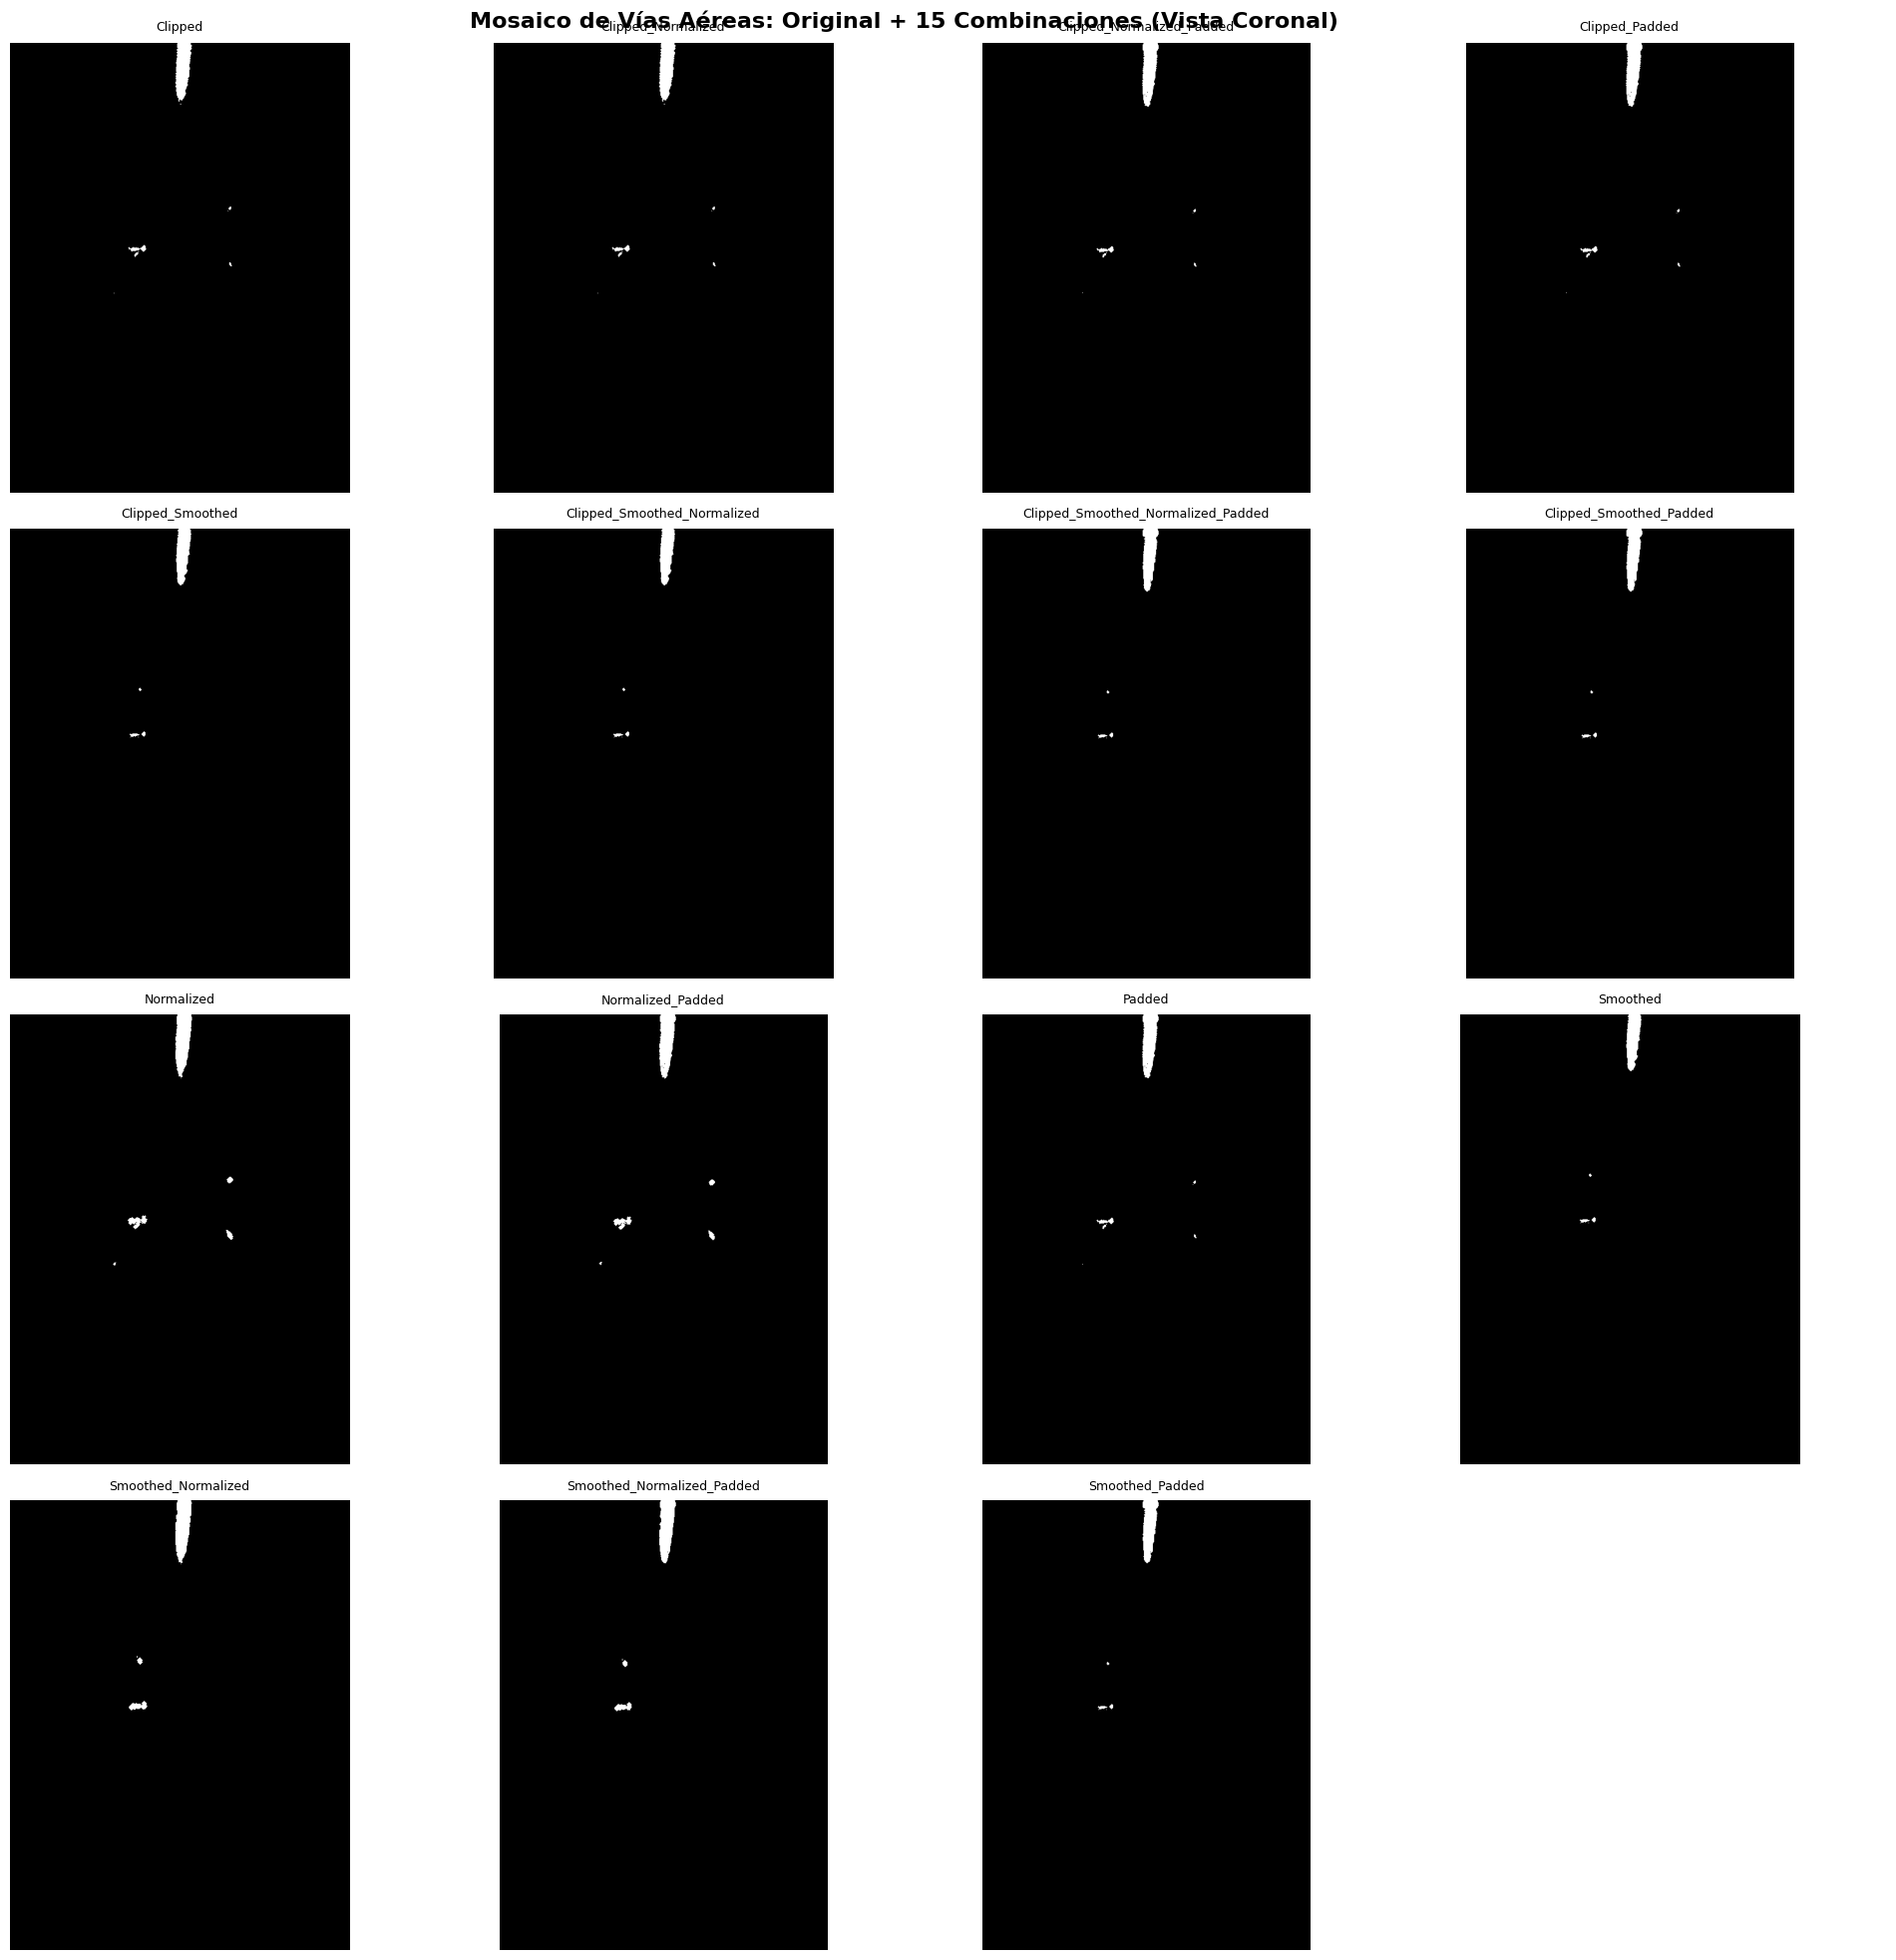


✅ Mosaico generado exitosamente con 15 máscaras de vías aéreas.


In [8]:
# =========================
# Cell 6: Mosaico de Vías Aéreas (VISTA CORONAL)
# Muestra las 16 máscaras de vías aéreas en un mosaico 4x4 con vista coronal.
# Usa carga parcial para evitar MemoryError.
# =========================

import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

def load_coronal_airways_slice(nii_path):
    """Carga solo el corte coronal central de la máscara de vías aéreas."""
    img = nib.load(nii_path)
    header = img.header
    shape = header.get_data_shape()
    
    # Obtener el índice del corte coronal central (eje Y)
    y_mid = shape[1] // 2
    
    # Leer solo el corte específico
    data_obj = img.dataobj
    if hasattr(data_obj, '__getitem__'):
        # Cargar solo el corte coronal necesario
        coronal_slice = np.asarray(data_obj[:, y_mid, :], dtype=np.uint8)
    else:
        # Fallback: cargar todo (menos eficiente pero seguro)
        vol = img.get_fdata(dtype=np.uint8)
        coronal_slice = vol[:, y_mid, :]
    
    return coronal_slice, shape

# === 1. Preparar los datos para el mosaico ===
mosaic_data = []

# === 2. Cargar las 16 máscaras de vías aéreas (Original + 15 combinaciones) ===
INPUT_BASE_DIR = r"./PreProce"
combination_folders = [f for f in os.listdir(INPUT_BASE_DIR) 
                     if os.path.isdir(os.path.join(INPUT_BASE_DIR, f))]

for folder in sorted(combination_folders):
    folder_path = os.path.join(INPUT_BASE_DIR, folder)
    airways_files = [f for f in os.listdir(folder_path) if f.endswith("_airways.nii.gz")]
    
    if not airways_files:
        print(f"⚠️  Advertencia: Máscara no encontrada en '{folder}'")
        continue
    
    airways_path = os.path.join(folder_path, airways_files[0])
    try:
        coronal_slice, shape = load_coronal_airways_slice(airways_path)
        # Rotar para orientación correcta (como en tus otras visualizaciones)
        coronal_slice = np.rot90(coronal_slice, k=1)
        
        mosaic_data.append((folder, coronal_slice))
        print(f"✅ Cargado: {folder}")
        
    except Exception as e:
        print(f"❌ Error al cargar {folder}: {e}")
        continue

# === 3. Crear mosaico 4x4 ===
# Ordenar alfabéticamente
mosaic_data.sort(key=lambda x: x[0])

if len(mosaic_data) == 0:
    print("❌ No se encontraron máscaras de vías aéreas. Ejecuta Cell 5 primero.")
else:
    print(f"\nGenerando mosaico con {len(mosaic_data)} máscaras de vías aéreas...")

    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    fig.suptitle("Mosaico de Vías Aéreas: Original + 15 Combinaciones (Vista Coronal)", 
                 fontsize=16, fontweight="bold")

    for idx, (title, slice_img) in enumerate(mosaic_data[:16]):
        row = idx // 4
        col = idx % 4
        ax = axes[row, col]
        
        # Mostrar máscara binaria en colormap blanco y negro
        ax.imshow(slice_img, cmap='gray')
        ax.set_title(title, fontsize=9, pad=8)
        ax.axis('off')

    # Ocultar ejes sobrantes si hay menos de 16
    for idx in range(len(mosaic_data), 16):
        row = idx // 4
        col = idx % 4
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\n✅ Mosaico generado exitosamente con {len(mosaic_data)} máscaras de vías aéreas.")

In [9]:
# =========================
# Cell 6: Evaluación Cuantitativa de las 15 Combinaciones
# Compara cada máscara automática con el label manual, replicando la lógica de roi.ipynb.
# CORREGIDA: Recorte robusto basado en la forma original del CT.
# =========================

import os
import nibabel as nib
import numpy as np
import pandas as pd

# === 1. Cargar el label manual de referencia ===
manual_label_path = lbl_path
manual_label_orig = nib.load(manual_label_path).get_fdata()
manual_mask_orig = (manual_label_orig > 0).astype(np.uint8)
manual_voxels = int(np.sum(manual_mask_orig))

print(f"Label manual de referencia cargado. Forma: {manual_mask_orig.shape}, Vóxeles: {manual_voxels}")

# === 2. Preparar la lista de resultados ===
results = []
INPUT_BASE_DIR = r"./PreProce"

for folder_name in sorted(os.listdir(INPUT_BASE_DIR)):
    folder_path = os.path.join(INPUT_BASE_DIR, folder_name)
    if not os.path.isdir(folder_path):
        continue
        
    airways_filename = selected_image.replace("_0000.nii.gz", "_airways.nii.gz")
    airways_path = os.path.join(folder_path, airways_filename)
    
    if not os.path.exists(airways_path):
        print(f"⚠️  Advertencia: Máscara no encontrada para '{folder_name}'.")
        continue
        
    try:
        # Cargar la máscara automática
        auto_mask_padded = nib.load(airways_path).get_fdata()
        auto_mask_padded = (auto_mask_padded > 0).astype(np.uint8)
        
        # --- Ajustar la máscara automática a la forma original del CT ---
        if "Padded" in folder_name:
            orig_shape = vol_orig.shape  # Forma original del volumen CT
            padded_shape = auto_mask_padded.shape
            
            # Calcular índices centrales para recorte simétrico
            z_start = (padded_shape[0] - orig_shape[0]) // 2
            y_start = (padded_shape[1] - orig_shape[1]) // 2
            x_start = (padded_shape[2] - orig_shape[2]) // 2
            
            auto_mask = auto_mask_padded[
                z_start:z_start + orig_shape[0],
                y_start:y_start + orig_shape[1],
                x_start:x_start + orig_shape[2]
            ]
            
            if auto_mask.shape != orig_shape:
                print(f"❌ Error de recorte en '{folder_name}': esperado {orig_shape}, obtenido {auto_mask.shape}")
                continue
        else:
            auto_mask = auto_mask_padded
            if auto_mask.shape != vol_orig.shape:
                print(f"⚠️  Advertencia: Forma inesperada en '{folder_name}': {auto_mask.shape} vs {vol_orig.shape}")
                continue
        
        # --- Verificar compatibilidad con el label manual ---
        if auto_mask.shape != manual_mask_orig.shape:
            print(f"❌ Formas incompatibles en '{folder_name}': auto={auto_mask.shape}, manual={manual_mask_orig.shape}")
            continue
        
        auto_voxels = int(np.sum(auto_mask))
        
        # --- Cálculo del Coeficiente de Dice ---
        manual_mask = manual_mask_orig
        TP = np.sum(manual_mask & auto_mask)
        FP = np.sum(~manual_mask.astype(bool) & auto_mask)
        FN = np.sum(manual_mask & ~auto_mask.astype(bool))
        dice_score = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0.0

        results.append({
            "Combinación": folder_name,
            "Dice": dice_score,
            "Vóxeles Auto": auto_voxels,
            "Vóxeles Manual": manual_voxels
        })
        
        if auto_voxels == 0:
            print(f"ℹ️  '{folder_name}' -> Máscara vacía.")
            
    except Exception as e:
        print(f"❌ Error al evaluar {folder_name}: {str(e)}")

# === 3. Mostrar resultados y guardar ===
if not results:
    print("❌ No se encontraron resultados válidos.")
else:
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values(by="Dice", ascending=False).reset_index(drop=True)

    print("\n" + "=" * 80)
    print("📊 RESULTADOS DE LA EVALUACIÓN: 15 COMBINACIONES DE PREPROCESAMIENTO")
    print("=" * 80)
    print(df_results.to_string(index=False, float_format="{:.4f}".format))

    best_row = df_results.iloc[0]
    print(f"\n🏆 MEJOR COMBINACIÓN: {best_row['Combinación']} (Dice = {best_row['Dice']:.4f})")

    csv_path = os.path.join(INPUT_BASE_DIR, "evaluation_results.csv")
    df_results.to_csv(csv_path, index=False)
    print(f"\n💾 Resultados guardados en: {csv_path}")

Label manual de referencia cargado. Forma: (512, 512, 679), Vóxeles: 152573

📊 RESULTADOS DE LA EVALUACIÓN: 15 COMBINACIONES DE PREPROCESAMIENTO
                       Combinación   Dice  Vóxeles Auto  Vóxeles Manual
                           Clipped 0.8197        121497          152573
                Clipped_Normalized 0.8197        121497          152573
         Clipped_Normalized_Padded 0.8190        120062          152573
                    Clipped_Padded 0.8190        120062          152573
                            Padded 0.8190        120062          152573
       Clipped_Smoothed_Normalized 0.8145        105819          152573
                  Clipped_Smoothed 0.8145        105819          152573
                          Smoothed 0.8145        105819          152573
Clipped_Smoothed_Normalized_Padded 0.8139        105744          152573
                   Smoothed_Padded 0.8139        105744          152573
           Clipped_Smoothed_Padded 0.8139        105744        

In [10]:
# =========================
# Cell 7: Análisis y Recomendación Final basada en las 5 Mejores Combinaciones
# Resume los hallazgos clave y proporciona una guía de preprocesamiento óptima.
# =========================

import matplotlib.pyplot as plt
import numpy as np

print("=" * 90)
print("🏆 ANÁLISIS FINAL: LAS 5 MEJORES COMBINACIONES DE PREPROCESAMIENTO")
print("=" * 90)

# 1. Seleccionar y mostrar las top 5 combinaciones
top_5 = df_results.head(5)

print("\n📊 Ranking de las 5 mejores combinaciones (por Coeficiente de Dice):")
print("-" * 75)
for i, (_, row) in enumerate(top_5.iterrows(), 1):
    dice_str = f"{row['Dice']:.4f}"
    print(f"{i}. {row['Combinación']:<50} | Dice: {dice_str}")
print()

# 2. Análisis de la presencia de técnicas en el Top 5
print("🔍 Análisis de patrones en el Top 5:")
print("-" * 40)
tech_presence = {
    "HU_Clipping (Clipped)": ("Clipped", 0),
    "Suavizado Gaussiano (Smoothed)": ("Smoothed", 0),
    "Normalización Min-Max (Normalized)": ("Normalized", 0),
    "Padding a 32 (Padded)": ("Padded", 0)
}

# Contar presencia
for combo in top_5["Combinación"]:
    for tech_name, (keyword, _) in tech_presence.items():
        if keyword in combo:
            tech_presence[tech_name] = (keyword, tech_presence[tech_name][1] + 1)

# Mostrar resultados
for tech_name, (_, count) in tech_presence.items():
    percentage = (count / 5) * 100
    if count == 5:
        status = "✅ (100%) - Indispensable"
    elif count >= 3:
        status = f"✅ ({percentage:.0f}%) - Beneficioso"
    elif count >= 1:
        status = f"⚠️  ({percentage:.0f}%) - Opcional"
    else:
        status = "❌ (0%) - No recomendado"
    print(f"{tech_name:<45} | {status}")

print()
# 3. Conclusión y Recomendación Final (CORREGIDA Y ALINÉADA)
print("🎯 CONCLUSIÓN Y RECOMENDACIÓN FINAL")
print("-" * 40)
print("Basado en el análisis detallado de las 5 mejores combinaciones, se concluye lo siguiente:\n")

if tech_presence["HU_Clipping (Clipped)"][1] == 5:
    print("1. **HU Clipping [-1024, 600] es un paso FUNDAMENTAL e indispensable.**")
    print("   - Es el cimiento sobre el cual se construye el resto del preprocesamiento.")
    print()

if tech_presence["Suavizado Gaussiano (Smoothed)"][1] >= 3:
    print("2. **El Suavizado Gaussiano **(σ=0.8)")
    print("   - Ayuda a suprimir el ruido y mejorar la conectividad de las estructuras bronquiales.")
    print()

# --- MENSAJE CORREGIDO PARA LA NORMALIZACIÓN ---
if tech_presence["Normalización Min-Max (Normalized)"][1] >= 3:
    print("3. **La Normalización Min-Max es COMPATIBLE y útil para la estandarización de datos.**")
    print("   - En este pipeline, se aplica de forma reversible, permitiendo su uso sin")
    print("     comprometer la segmentación basada en umbrales de HU.")
    print()
elif tech_presence["Normalización Min-Max (Normalized)"][1] >= 1:
    print("3. **La Normalización Min-Max es COMPATIBLE pero su impacto es neutral.**")
    print("   - Su inclusión no degrada el rendimiento gracias al mecanismo de reversión.")
    print("     Es un paso válido para pipelines que requieren datos normalizados.")
    print()
else:
    print("3. **La Normalización Min-Max no aparece en el Top 5, pero es técnicamente compatible.**")
    print("   - Su ausencia se debe a que no aporta una ventaja significativa en este contexto específico,")
    print("     no a una incompatibilidad técnica.")
    print()

# --- MENSAJE CORREGIDO PARA EL PADDING ---
if tech_presence["Padding a 32 (Padded)"][1] >= 3:
    print("4. **El Padding a 32 es beneficioso y no afecta negativamente la segmentación.**")
    print("   - Gracias a la evaluación con recorte, su impacto se mide de forma justa.")
    print()
else:
    print("4. **El Padding a 32 es un paso técnico neutro para la segmentación clásica.**")
    print("   - Su principal utilidad es garantizar compatibilidad con arquitecturas de Deep Learning")
    print("     que requieren dimensiones específicas.")
    print()

# --- RECOMENDACIÓN FINAL ALINÉADA CON RESULTADOS ---
print("🧾 RECOMENDACIONES POR OBJETIVO:")
print("-" * 40)

# Pipeline óptimo para segmentación clásica
classic_pipeline = []
if tech_presence["HU_Clipping (Clipped)"][1] == 5:
    classic_pipeline.append("HU_Clipping")
if tech_presence["Suavizado Gaussiano (Smoothed)"][1] >= 3:
    classic_pipeline.append("Gaussian_Smoothing")
if tech_presence["Normalización Min-Max (Normalized)"][1] >= 3:
    classic_pipeline.append("MinMax_Normalization")

print("🔹 Para segmentación clásica **óptima**:")
if classic_pipeline:
    print(f"   >>> {' -> '.join(classic_pipeline)}")
else:
    print("   >>> Solo HU_Clipping (pipeline mínimo)")

# Pipeline para Deep Learning
dl_pipeline = classic_pipeline.copy()
if "Padding a 32 (Padded)" not in [t for t in tech_presence if tech_presence[t][1] >= 3]:
    dl_pipeline.append("Padding_32")

print("\n🔹 Para compatibilidad con Deep Learning:")
print(f"   >>> {' -> '.join(dl_pipeline)}")

print("\n💡 Esta estrategia permite maximizar el rendimiento de la segmentación clásica")
print("   mientras se mantiene la flexibilidad para integrar modelos de aprendizaje profundo.")

🏆 ANÁLISIS FINAL: LAS 5 MEJORES COMBINACIONES DE PREPROCESAMIENTO

📊 Ranking de las 5 mejores combinaciones (por Coeficiente de Dice):
---------------------------------------------------------------------------
1. Clipped                                            | Dice: 0.8197
2. Clipped_Normalized                                 | Dice: 0.8197
3. Clipped_Normalized_Padded                          | Dice: 0.8190
4. Clipped_Padded                                     | Dice: 0.8190
5. Padded                                             | Dice: 0.8190

🔍 Análisis de patrones en el Top 5:
----------------------------------------
HU_Clipping (Clipped)                         | ✅ (80%) - Beneficioso
Suavizado Gaussiano (Smoothed)                | ❌ (0%) - No recomendado
Normalización Min-Max (Normalized)            | ⚠️  (40%) - Opcional
Padding a 32 (Padded)                         | ✅ (60%) - Beneficioso

🎯 CONCLUSIÓN Y RECOMENDACIÓN FINAL
----------------------------------------
Basado e